## Analysis and helper plots to compare our model options to the glacierMIP2 disequilibrium temperature sensitivity:

In [6]:
# data path -> data created from 00_data_creating scripts
data_path = '/home/users/lschuster/Schuster_et_al_phd_paper_1_cluster/01_data'
# path where OGGM gdirs are: is created in data_creating_scripts
working_dir = '/home/users/lschuster/Schuster_et_al_phd_paper_1_cluster/oggm_run_gdir_folder/node_folder'

In [7]:
import seaborn as sns
import matplotlib
import xarray as xr
import matplotlib.pyplot as plt
plt.rc('font', size=20)
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  # noqa: E402
import scipy
import numpy as np
import pandas as pd

# imports from OGGM
import oggm
from oggm import utils, workflow, tasks, cfg, entity_task
import MBsandbox
from MBsandbox.mbmod_daily_oneflowline import (TIModel_Sfc_Type, TIModel, process_w5e5_data)
from MBsandbox.wip.projections_bayescalibration import process_isimip_data, process_isimip_data_no_corr
from MBsandbox.help_func import (minimize_winter_mb_brentq_geod_via_pf, minimize_bias_geodetic,
                                 calibrate_to_geodetic_bias_winter_mb)
from MBsandbox.mbmod_daily_oneflowline import compile_fixed_geometry_mass_balance_TIModel

import time
import logging

In [8]:
log = logging.getLogger(__name__)

base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')
climate_type = 'W5E5'

# get the geodetic calibration data
pd_geodetic_all = utils.get_geodetic_mb_dataframe()
# pd_geodetic_all = pd.read_hdf(path_geodetic, index_col='rgiid')
pd_geodetic = pd_geodetic_all.loc[pd_geodetic_all.period == '2000-01-01_2020-01-01']

_, pathi = utils.get_wgms_files()
pd_mb_overview = pd.read_csv(pathi[:-len('/mbdata')] + '/mb_overview_seasonal_mb_time_periods_20220301.csv',
                             index_col='Unnamed: 0')
pd_wgms_data_stats = pd.read_csv(pathi[:-len('/mbdata')] + '/wgms_data_stats_20220301.csv', index_col='Unnamed: 0')

# should have at least 5 annual MB estimates in the time period 1980-2019
# (otherwise can also not have MB profiles or winter MB!)
pd_wgms_data_stats = pd_wgms_data_stats.loc[pd_wgms_data_stats.len_annual_balance>=5]
ref_candidates = pd_wgms_data_stats.rgi_id.unique()

cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True #True
cfg.PATHS['working_dir'] = working_dir
cfg.PARAMS['hydro_month_nh'] = 1
cfg.PARAMS['hydro_month_sh'] = 1
cfg.PARAMS['continue_on_error'] = True
warnings.filterwarnings("ignore", category=DeprecationWarning) 

correction = False

load = False
if load:
    gdirs = workflow.init_glacier_directories(
                ref_candidates)
    
    if correction:
        workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                 ssp = ssp, temporal_resol ='monthly',
                                  climate_historical_filesuffix='_{}_{}'.format('monthly', climate_type) )
        workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                 ssp = ssp, temporal_resol ='daily',
                                  climate_historical_filesuffix='_{}_{}'.format('daily', climate_type) )
    else:
        #workflow.execute_entity_task(process_isimip_data_no_corr, gdirs, ensemble = ensemble,
        #                         ssp = ssp, temporal_resol ='monthly',
        #                          climate_historical_filesuffix='_{}_{}'.format('monthly', climate_type) )
        #workflow.execute_entity_task(process_isimip_data_no_corr, gdirs, ensemble = ensemble,
        #                         ssp = ssp, temporal_resol ='daily',
        #                          climate_historical_filesuffix='_{}_{}'.format('daily', climate_type) )
        workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                 ssp = 'ssp126', temporal_resol ='monthly',
                                  climate_historical_filesuffix='_{}_{}'.format('monthly', climate_type), correct=correction )
        workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                 ssp = 'ssp126', temporal_resol ='daily',
                                  climate_historical_filesuffix='_{}_{}'.format('daily', climate_type), correct=correction )
        workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                 ssp = 'ssp585', temporal_resol ='monthly',
                                  climate_historical_filesuffix='_{}_{}'.format('monthly', climate_type), correct=correction )
        workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                         ssp = 'ssp585', temporal_resol ='daily',
                                          climate_historical_filesuffix='_{}_{}'.format('daily', climate_type), correct=correction )
        
    #else:
    #t = workflow.execute_entity_task(process_w5e5_data, gdirs, climate_type=baseline_climate,
    #                              temporal_resol='monthly')
    #else:
    #t = workflow.execute_entity_task(process_w5e5_data, gdirs, climate_type=baseline_climate,
    #                          temporal_resol='daily')
    #t = workflow.execute_entity_task(process_era5_daily_data, gdirs, #climate_type=baseline_climate,
                              #temporal_resol='daily'process_era5_daily_data(gd)
    #                                )
else:
    do_not_load_gdirs = False
    if do_not_load_gdirs:
        pass
    else:
        gdirs = workflow.init_glacier_directories(ref_candidates)
                                 
        _doc = 'the calibrated melt_f, pf and temp.b to match geodetic mean observation, winter MB and approximately std of direct annual time series'
        cfg.BASENAMES['calib_geod_opt_winter_mb_approx_std'] = ('melt_f_geod_opt_winter_mb_approx_std.json', _doc)

        _doc2 = 'the calibrated melt_f and pf to match geodetic mean observation and winter MB bias, temp. bias set to zero!'
        cfg.BASENAMES['calib_geod_opt_winter_mb_temp_b_0'] = ('calib_geod_opt_winter_mb_temp_b_0.json', _doc2)

        _doc3 = 'the calibrated melt_f and pf to match geodetic mean observation and interannual direct glaciological standard deviation, temp. bias set to zero!'
        cfg.BASENAMES['calib_geod_opt_std_temp_b_0'] = ('calib_geod_opt_std_temp_b_0.json', _doc3)

        _doc4 = 'the calibrated melt_f to match geodetic mean observation, no temp. bias and globally cte prcp. fac extracted from median of ref glacier matching direct glaciological standard deviation'
        cfg.BASENAMES['calib_only_geod_temp_b_0_pf_cte_via_std'] = ('calib_only_geod_temp_b_0_pf_cte_via_std.json', _doc4)

        _doc5 = 'the calibrated melt_f to match geodetic mean observation, no temp. bias and per glacier one prcp. factor extracted from median of ref glacier matching direct glaciological standard deviation'
        cfg.BASENAMES['calib_only_geod_temp_b_0_pf_fit_via_winter_mb'] = ('calib_only_geod_temp_b_0_pf_fit_via_winter_mb.json', _doc5)


2023-01-13 13:04:37: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-01-13 13:04:37: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-01-13 13:04:37: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-01-13 13:04:37: oggm.cfg: Multiprocessing switched ON after user settings.
2023-01-13 13:04:37: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2023-01-13 13:04:37: oggm.workflow: Execute entity tasks [GlacierDirectory] on 247 glaciers


In [14]:
pd_params_stats_working_for_all = pd.read_csv(f'{data_path}/0_pd_params_stats_working_for_all.csv')
gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
calib_types = ['calib_geod_opt_winter_mb_approx_std', 'calib_geod_opt_winter_mb_temp_b_0', 'calib_geod_opt_std_temp_b_0',
               'calib_only_geod_temp_b_0_pf_cte_via_std', 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb']


def get_deltaT_specMB(gdir, ssp='ssp126', gcm='gfdl-esm4_r1i1p1f1',
                     calib='calib_geod_opt_std_temp_b_0'):
    calib_types = ['calib_geod_opt_winter_mb_approx_std', 'calib_geod_opt_winter_mb_temp_b_0',
                   'calib_geod_opt_std_temp_b_0',
               'calib_only_geod_temp_b_0_pf_cte_via_std', 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb']
    
    clim_h_path = gdir.get_filepath('climate_historical', filesuffix='_daily_W5E5')
    temp_h_annual = xr.open_dataset(clim_h_path).temp.sel(time=slice('2000','2020')).groupby('time.year').mean()
    clim_f_path = gdir.get_filepath('gcm_data', filesuffix=f'_monthly_ISIMIP3b_{gcm}_{ssp}_no_correction')
    temp_f_annual = xr.open_dataset(clim_f_path).temp.sel(time=slice('2020','2100')).groupby('time.year').mean()

    deltaT = xr.concat([temp_h_annual, temp_f_annual], dim='year')-temp_h_annual.mean()
    deltaT = deltaT.to_dataframe().loc[2021:]  # rename(columns={'temp':gdir.rgi_id})

    spec_mb_l = []
    for calib_type in calib_types:
        for sfc_type in ['False', 'neg_exp', 'linear']:
            for grad_type in ['cte', 'var_an_cycle']:
                for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:
                    fmd = gdir.get_filepath('model_diagnostics',
                                      filesuffix=f'_gcm_run_{gcm}_{ssp}_{calib}_{mb_type}_{grad_type}_{sfc_type}_monthly')
                    ds_vol = xr.open_dataset(fmd).volume_m3
                    ds_area = xr.open_dataset(fmd).area_m2
                    deltaV = ds_vol.sel(time=slice('2021','2101'))- ds_vol.sel(time=slice('2020','2100')).values
                    #deltaA = ds_area.sel(time=slice('2021','2101'))-ds_area.sel(time=slice('2020','2100')).values

                    spec_mb = deltaV*900 / ds_area.sel(time=slice('2021','2101'))
                    #deltaT['rgi_id'] = gdir.rgi_id
                    #deltaT['gcm'] = gcm
                    #deltaT['ssp'] = ssp
                    spec_mb = spec_mb.to_dataframe(name='spec_mb')[['spec_mb']]
                    spec_mb['deltaT'] = deltaT['temp'].values
                    spec_mb['rgi_id'] = gdir.rgi_id
                    spec_mb['gcm'] = gcm
                    spec_mb['ssp'] = ssp
                    spec_mb['area'] = ds_area.sel(time=slice('2021','2101'))
                    spec_mb = spec_mb.reset_index()
                    spec_mb['time'] = spec_mb.time.astype(int)
                    spec_mb['sfc_type'] = sfc_type
                    spec_mb['calib_type'] = calib_type
                    spec_mb['grad_type'] = grad_type
                    spec_mb['mb_type'] = mb_type
                    spec_mb_l.append(spec_mb)
    return pd.concat(spec_mb_l, axis=0)

In [15]:
# just create an empty dataframe ...
calib = 'calib_only_geod_temp_b_0_pf_fit_via_winter_mb'
spec_mb = pd.DataFrame(columns=get_deltaT_specMB(gdirs[12]).columns)
deltaT_d = {}
spec_mb_d = {}
gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
load = True
if load:
    for gdir in gdirs:
        if gdir.rgi_id in pd_params_stats_working_for_all.rgi_id.unique():
            for ssp in ['ssp126','ssp585']:
                for gcm in gcms:
                    if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
                        ensemble = 'r1i1p1f1'
                    elif gcm == 'ukesm1-0-ll':
                        ensemble = 'r1i1p1f2'
                    gcm = f'{gcm}_{ensemble}'
                    try:
                        _spec_mb = get_deltaT_specMB(gdir, ssp=ssp, gcm=gcm, calib=calib)
                        _spec_mb.loc[(_spec_mb['spec_mb']==-np.inf), 'spec_mb'] = np.NaN
                        assert not np.any(_spec_mb['spec_mb']==-np.inf)
                        spec_mb = pd.concat([spec_mb, _spec_mb], axis=0)

                    except:
                        pass
        else:
            pass
    spec_mb.to_csv(f'{data_path}/additional/glacierMIP2_comp_deltaT_spec_mb_evolution_all_options.csv')
else:
    spec_mb = pd.read_csv(f'{data_path}/additional/glacierMIP2_comp_deltaT_spec_mb_evolution_all_options.csv', index=[0])
    
    
    
mdiseq_l = []
mu_l = []
yr_l = []
sfc_type_l = []
mb_type_l = []
grad_type_l = []
calib_type_l = []
pd_regress = pd.DataFrame(columns=['year', 'calib_type','sfc_type','mb_type','grad_type',
                                   'mu', 'mdiseq'])
#_spec_mb = spec_mb.loc[(spec_mb.rgi_id=='RGI60-11.01450')]
#_spec_mb = spec_mb.groupby(['time','gcm','ssp','sfc_type']).sum().reset_index()
single_rgi = False
if single_rgi:
    _spec_mb = spec_mb.loc[(spec_mb.rgi_id=='RGI60-11.00897')]
else:
    _spec_mb = spec_mb.groupby(['time','gcm','ssp','calib_type','sfc_type','mb_type','grad_type']).mean().reset_index()
    def calculator(df):
        weighted_sum = (df['spec_mb']*df['area']).sum()/df['area'].sum()
        return weighted_sum
    _spec_mb['spec_mb_w'] = spec_mb.groupby(['time','gcm','ssp','calib_type','sfc_type','mb_type','grad_type',]).apply(lambda x: calculator(x)).values

for calib_type in calib_types:
    for sfc_type in ['False', 'neg_exp', 'linear']:
        for grad_type in ['cte', 'var_an_cycle']:
            for mb_type in ['mb_monthly', 'mb_pseudo_daily', 'mb_real_daily']:
                for yr in np.arange(2021,2101,1):
                    _spec_mb_sel = _spec_mb.loc[(_spec_mb.time==yr) & (_spec_mb.sfc_type==sfc_type)]
                    spec_mb_sel = _spec_mb_sel.loc[(_spec_mb_sel.calib_type==calib) & 
                                                   (_spec_mb_sel.mb_type==mb_type) &
                                                   (_spec_mb_sel.grad_type==grad_type)]

                    mu,mdiseq,rval,pval,se = scipy.stats.linregress(spec_mb_sel.deltaT, y=spec_mb_sel.spec_mb_w)

                    if pval >= 0.1:
                        mu_l.append(np.NaN)
                        mdiseq_l.append(np.NaN)
                    else:
                        mu_l.append(mu)
                        mdiseq_l.append(mdiseq)
                    yr_l.append(yr)
                    sfc_type_l.append(sfc_type)
                    calib_type_l.append(calib_type)
                    mb_type_l.append(mb_type)
                    grad_type_l.append(grad_type)

pd_regress['year'] = yr_l
pd_regress['sfc_type'] = sfc_type_l
pd_regress['calib_type'] = calib_type_l
pd_regress['mb_type'] = mb_type_l
pd_regress['grad_type'] = grad_type_l

pd_regress['mu'] = mu_l
pd_regress['mdiseq'] = mdiseq_l


pd_regress['mdiseq_10yravg'] = pd_regress['mdiseq'].dropna().rolling(10).mean()
pd_regress['mu_10yravg'] = pd_regress['mu'].dropna().rolling(10).mean()



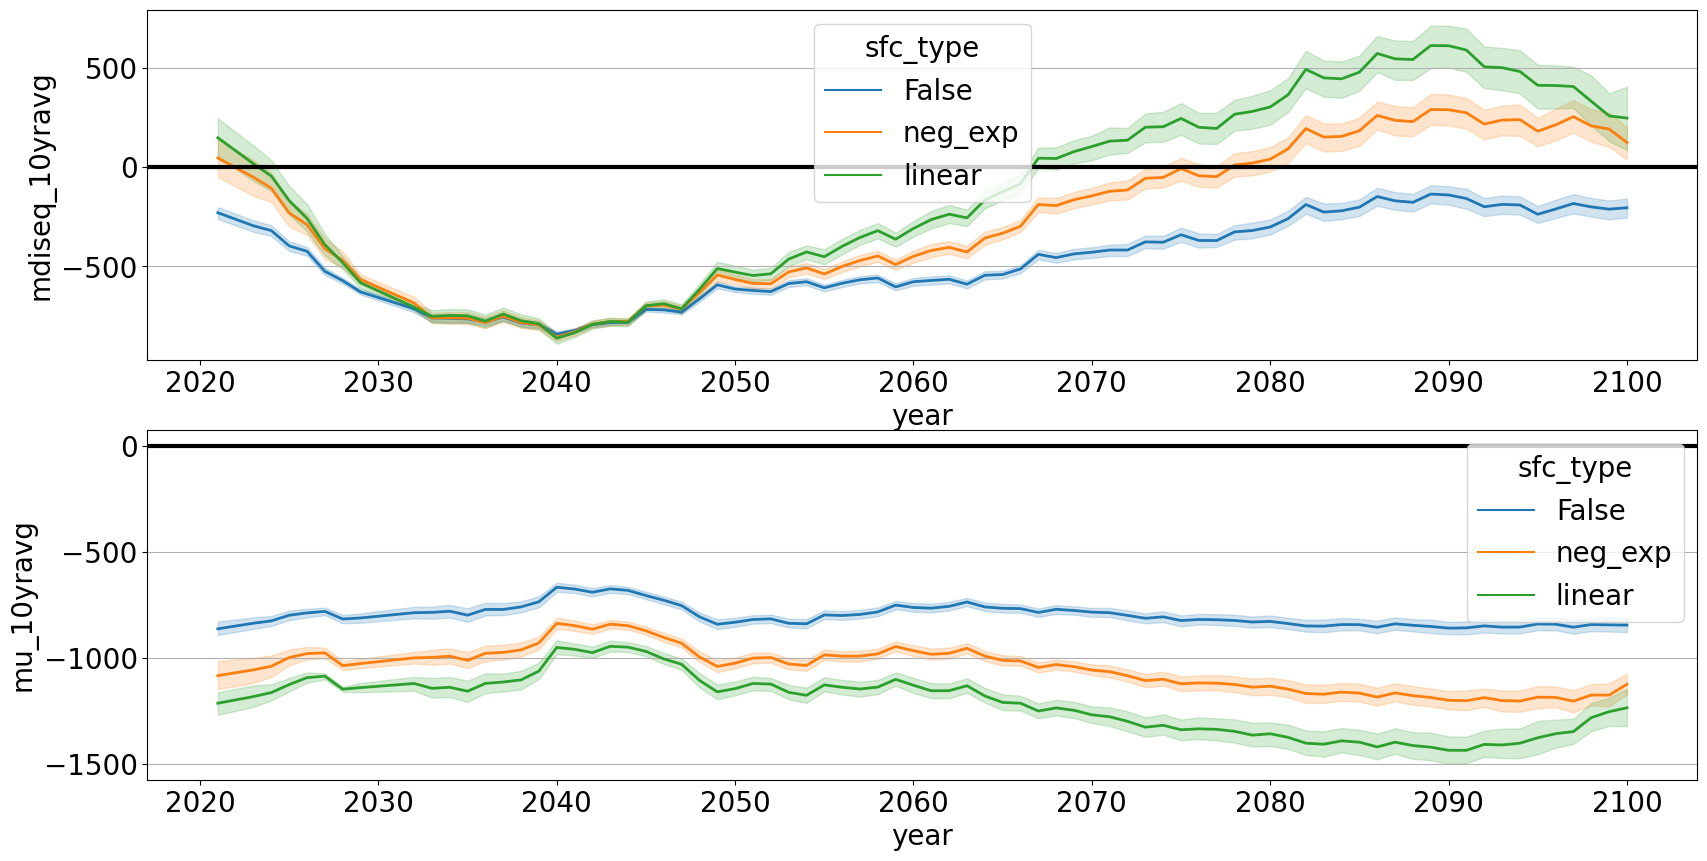

In [16]:
pd_regress_sel = pd_regress #.loc[(pd_regress.calib_type==calib_types[-1])]
fig, axs = plt.subplots(2,1,figsize=(20,10))
sns.lineplot(x='year', y='mdiseq_10yravg', hue='sfc_type', data=pd_regress_sel.dropna(), ax=axs[0],lw=2)
sns.lineplot(x='year', y='mu_10yravg', hue='sfc_type', data=pd_regress_sel.dropna(), ax=axs[1],lw=2)
axs[0].axhline(0, color='black',lw=3)
axs[0].grid(axis='y')
axs[1].axhline(0, color='black',lw=3)
axs[1].grid(axis='y')

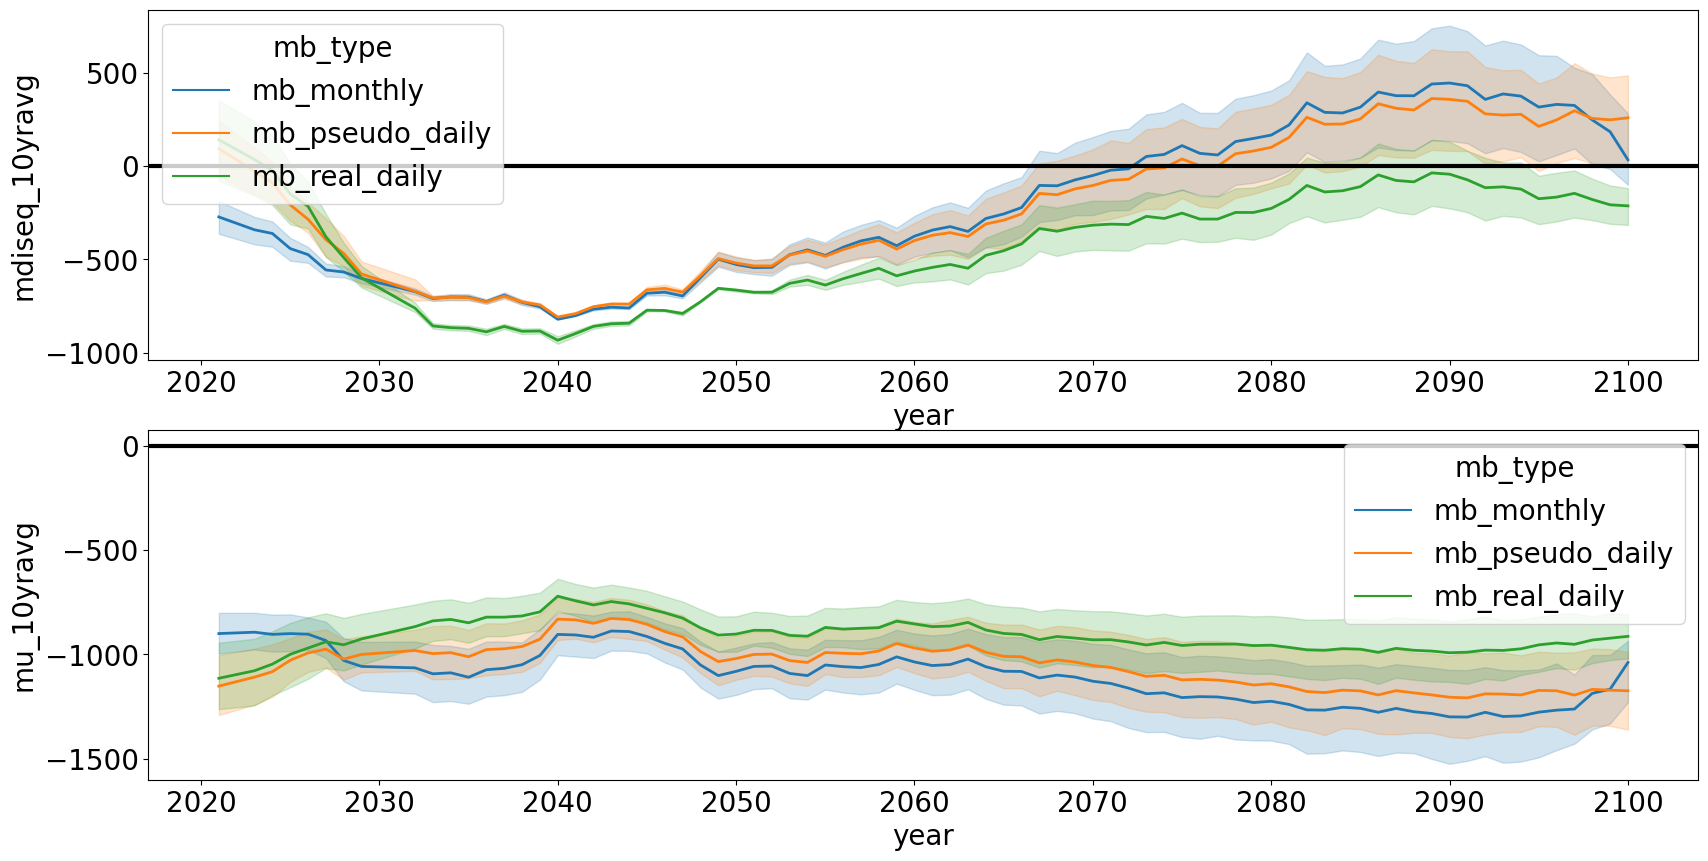

In [17]:
pd_regress_sel = pd_regress.loc[(pd_regress.calib_type==calib_types[-1])]
fig,axs = plt.subplots(2,1,figsize=(20,10))
sns.lineplot(x='year', y='mdiseq_10yravg', hue='mb_type', data=pd_regress_sel.dropna(), ax=axs[0],lw=2)
sns.lineplot(x='year', y='mu_10yravg', hue='mb_type', data=pd_regress_sel.dropna(), ax=axs[1],lw=2)
axs[0].axhline(0, color='black',lw=3)
axs[1].axhline(0, color='black',lw=3)

- weighted onthe current glacier area -> not sure if this makes any sense
- on average, a more negative disequilibrium at the beginning and a less positive disequilibrium at the end when not including sfc type options and/or using daily instead of monthly data 
- a less negative temperature sensitivity when not including surface type distinction or/and using daily instead of monthly data ...  
    - for sfc type distinctions: both aspects are somehow visible for GlacierMIP2 (i.e. OGGM as a model without sfc type distinction compared to  although it is difficult to disentangle the sources ... 